In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, regularizers, initializers
import random
import time
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
N = 1000

d = 10
P = 10
K = 2
mu = 0
sigma = 1
train_size = 800
m = 100

In [3]:
def generateAdj(N, p1, p2):
    adj_matrix = np.eye(N)
    for i in range(N-1):
        for j in range(N-i-1):
            if i < c:
                adj_matrix[i,i+j+1] = np.random.binomial(1,p1, 1);
            else:
                adj_matrix[i, i + j + 1] = np.random.binomial(1, p2, 1);
            adj_matrix[i+j+1,i] = adj_matrix[i,i+j+1];
    return adj_matrix

def l2_loss(logits, labels, mask):
    # use l_2 loss (regression loss)
    #loss = tf.losses.mean_squared_error (labels, logits)
    #loss = tf.nn.l2_loss(labels - logits)
    loss = tf.math.square(tf.norm(labels - logits, axis=1, ord=2))/2
    # taking mean over the number of traning data
    mask = tf.cast(mask, dtype=tf.float32)
    mask /= tf.reduce_mean(mask)
    loss *= mask
    return tf.reduce_mean(loss)
c = 100
def generateAdj(N, p1, p2):
    adj_matrix = np.eye(N)
    for i in range(N-1):
        for j in range(N-i-1):
            if i < c:
                adj_matrix[i,i+j+1] = np.random.binomial(1,p1, 1)
            else:
                adj_matrix[i, i + j + 1] = np.random.binomial(1, p2, 1)
            adj_matrix[i+j+1,i] = adj_matrix[i,i+j+1]
    return adj_matrix

def generate_norm_adj_matrix(adj_matrix):
    adj_matrix = adj_matrix.astype('float32')
    deg_matrix = tf.reduce_sum(adj_matrix, axis=-1)
    deg_group = np.array([tf.reduce_mean(deg_matrix[0:tf.cast(c-1, tf.int32)]), tf.reduce_mean(deg_matrix[tf.cast(N-c, tf.int32): N-1])])
    norm_deg_matrix = tf.linalg.diag(1.0 / tf.sqrt(deg_matrix))
    norm_adj_matrix = tf.matmul(norm_deg_matrix, tf.matmul(adj_matrix, norm_deg_matrix))
    return norm_adj_matrix

In [4]:
def generateWeight(mu, sigma, d, P):
    # W d*P
    return np.random.normal(mu, sigma, (d, P))

def generateVeight(mu, sigma, K, P):
    # V d*P
    return np.random.normal(mu, sigma, (K, P))

def generateC(mu, sigma, P, K):
    # C P*K
    return np.random.normal(mu, sigma, (P, K))

def generateX(mu, sigma, N, d):
    return np.random.normal(mu, sigma, (N, d))

def generate_data(A_star, X, W, V, C, alpha):
    # A_star N*N, X N*d, W d*p, V K*p, C p*K,
    node_labels = np.matmul(np.multiply(tf.matmul(A_star, tf.matmul(X, W)),
                               np.tanh(tf.matmul(A_star, tf.matmul(X, W)))), C)
    node_labels_F = np.matmul(tf.matmul(A_star, tf.matmul(X, W)), C) # N*k
    # node_labels_G_F = np.matmul(np.sin(tf.matmul(A_star, tf.matmul(node_labels_F, V))), C) #N*k
    node_labels_G_F = np.matmul(tf.matmul(A_star, tf.matmul(node_labels_F, V))**5, C) #N*k
    node_labels_F = np.matmul(tf.matmul(A_star, tf.matmul(X, W)), C) # N*k
    node_labels_G_F = np.matmul(np.multiply(np.sin(tf.matmul(A_star, tf.matmul(node_labels_F, V))),
                                               np.tanh(tf.matmul(A_star, tf.matmul(node_labels_F, V)))), C)
    node_labels_H = node_labels_F+ alpha * node_labels_G_F
    return node_labels_H

def createMask(index, N):
    mask = np.zeros(N)
    for i in index:
        mask[i] = 1
    return mask

In [5]:
learning_rate = 1e-4

optimizer = tf.optimizers.Adam(learning_rate)

def run_optimization(node_features, node_labels, A_star, test_error):
    # Wrap computation inside a GradientTape for automatic differentiation.
    index_batch = set(random.sample(train_index, batch_size))
    train_mask = createMask(index_batch, N)
    # 产生batch数量相对应的mask矩阵
    with tf.GradientTape() as t:
        # Forward pass.
        logits = cora_gnn(node_features, A_star)
        # Compute loss.
        loss = l2_loss(logits, node_labels, train_mask) #train_mask

    # Variables to update, i.e. trainable variables.
    variables = t.watched_variables()

    # Compute gradients.
    gradients = t.gradient(loss, variables)

    # Update W and b following gradients.
    optimizer.apply_gradients(zip(gradients, variables))
    val_mse = l2_loss(logits, node_labels, val_mask)
    test_mse = l2_loss(logits, node_labels, test_mask)
    test_error.append(test_mse)
    if epoch % 500 == 0:
        print('Iteration', epoch, '| Training loss:', loss.numpy(), '| Val MSE:'
                      , val_mse.numpy(), '| Test MSE', test_mse.numpy())

In [6]:
N = 1000
m = 100
d = 10
P = 10
K = 2
mu = 0
sigma = 1

W = generateWeight(mu, sigma, d, P)
W = W.astype('float32')
C = generateC(mu, sigma, P, K)
C = C.astype('float32')
V = generateVeight(mu, sigma, K, P)
V = V.astype('float32')

In [7]:
train_size = int(N*0.8)


batch_size = 50
random.seed(time.time())
test_index = set(range(N))
train_index = set(random.sample(test_index, train_size))
index_batch = set(random.sample(train_index, batch_size))
train_mask = createMask(index_batch, N)
test_index.difference_update(train_index)


val_size = int((N - train_size) / 2)
val_index = set(random.sample(test_index, val_size))
test_index.difference_update(val_index)

val_mask = createMask(val_index, N)
test_mask = createMask(test_index, N)
node_features = generateX(mu, sigma, N, d)
node_features = node_features.astype('float32')
X = node_features

adj_matrix = generateAdj(N, 0.3, 0.1)
norm_adj_matrix = generate_norm_adj_matrix(adj_matrix)
A_star = norm_adj_matrix


alpha = 5
node_labels_100_A1 = generate_data(A_star, X, W, V, C, alpha)

colsums = []
for i in np.arange(N):
    v = np.sum(np.abs(A_star[:, i]))
    colsums.append(v)
print(np.max(colsums))

1.5996549


In [8]:
# sample=0.1
from numpy import linalg as LA
aa = tf.random.uniform(shape=[N,N])+tf.eye(N)
sample_A1 = (tf.sign(aa-0.1)+1)*0.5
LA.norm(A_star-A_star*sample_A1, 'fro')

0.84057164

Iteration 0 | Training loss: 11.80993 | Val MSE: 14.386673 | Test MSE 14.909024
Iteration 500 | Training loss: 10.509012 | Val MSE: 11.022484 | Test MSE 11.649223
Iteration 1000 | Training loss: 9.507565 | Val MSE: 7.5687904 | Test MSE 8.302365
Iteration 1500 | Training loss: 4.568455 | Val MSE: 6.048555 | Test MSE 6.839249
Iteration 2000 | Training loss: 7.060418 | Val MSE: 5.6793523 | Test MSE 6.4664617
Iteration 2500 | Training loss: 6.73804 | Val MSE: 5.46504 | Test MSE 6.1742463


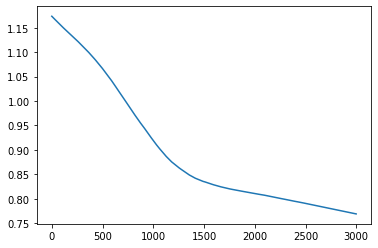

In [9]:
m = 20
hidden_units_1 = m
hidden_units_2 = m

layer_1 = tf.keras.layers.Dense(units=hidden_units_1, kernel_initializer=initializers.glorot_normal())
layer_2 = tf.keras.layers.Dense(units=hidden_units_2, kernel_initializer=initializers.glorot_normal())# hidden layer: apply weights
out = layers.Dense(K, kernel_initializer=initializers.random_normal(mean=0.0,stddev=1)
                       ,kernel_regularizer=None)  # K (2) classes for nodes

def gnn(node_features, adj_matrix, transform, activation):
    # weight first, then aggregate neighbor features
    #weighted_features = transform(node_features) # apply weights to node features
    #aggregated_features = tf.matmul(adj_matrix, weighted_features) # aggregated neighbor node features
    #return activation(aggregated_features) # apply activation function
    # aggregate neighbor features first, then weight
    aggregated_features = tf.matmul(adj_matrix, tf.cast(node_features, dtype=tf.float32)) # aggregated neighbor node features
    weighted_features = transform(aggregated_features) # apply weights to node features
    return activation(weighted_features) # apply activation function

def cora_gnn(node_features, adj_matrix):
    hidden_1 = gnn(node_features, sample_A1 * adj_matrix, layer_1, tf.nn.relu)
    hidden_2 = gnn(hidden_1, adj_matrix, layer_2, tf.nn.relu)
    # hidden_2 = layers.Dropout(rate=0.4)(hidden_2)
    # logits = gnn(hidden, adj_matrix, layer_2, tf.identity)
    added12 = tf.keras.layers.Add()([hidden_1, hidden_2])
    logits = tf.identity(out(added12))
    # logits = tf.identity(out(hidden_2))
    return logits

learning_rate = 1
test_error_100_A1 = []
epochs = 3000
for epoch in range(epochs):
    run_optimization(node_features, node_labels_100_A1, A_star, test_error_100_A1)
    if epoch % 500 == 0:
        learning_rate = learning_rate * 0.9
fig, ax = plt.subplots()
line1, = ax.plot(np.log10(test_error_100_A1), label='test_error_100_A1')

Iteration 0 | Training loss: 1.7301252 | Val MSE: 1.335276 | Test MSE 1.5667806
Iteration 500 | Training loss: 0.14130217 | Val MSE: 0.13242304 | Test MSE 0.16620216
Iteration 1000 | Training loss: 0.05394762 | Val MSE: 0.0760299 | Test MSE 0.09461194
Iteration 1500 | Training loss: 0.059784003 | Val MSE: 0.05097034 | Test MSE 0.060588885
Iteration 2000 | Training loss: 0.032345276 | Val MSE: 0.036408488 | Test MSE 0.039645243
Iteration 2500 | Training loss: 0.028287878 | Val MSE: 0.029584205 | Test MSE 0.030149441


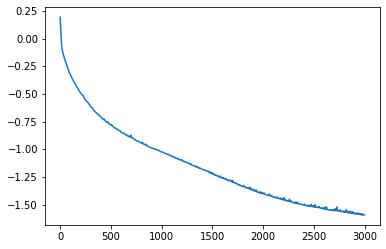

In [38]:
hidden_units_1 = m
hidden_units_2 = m
aa = tf.random.uniform(shape=[N,N])+tf.eye(N)
sample_A1 = (tf.sign(aa-0.1)+1)*0.5

layer_1 = tf.keras.layers.Dense(units=hidden_units_1, kernel_initializer=initializers.glorot_normal())
layer_2 = tf.keras.layers.Dense(units=hidden_units_2, kernel_initializer=initializers.glorot_normal())# hidden layer: apply weights
out = layers.Dense(K, kernel_initializer=initializers.random_normal(mean=0.0,stddev=1)
                       ,kernel_regularizer=None)  # K (2) classes for nodes

def gnn(node_features, adj_matrix, transform, activation):
    # weight first, then aggregate neighbor features
    #weighted_features = transform(node_features) # apply weights to node features
    #aggregated_features = tf.matmul(adj_matrix, weighted_features) # aggregated neighbor node features
    #return activation(aggregated_features) # apply activation function
    # aggregate neighbor features first, then weight
    aggregated_features = tf.matmul(adj_matrix, tf.cast(node_features, dtype=tf.float32)) # aggregated neighbor node features
    weighted_features = transform(aggregated_features) # apply weights to node features
    return activation(weighted_features) # apply activation function

def cora_gnn(node_features, adj_matrix):
    hidden_1 = gnn(node_features, adj_matrix, layer_1, tf.nn.relu)
    hidden_2 = gnn(hidden_1, sample_A1 * adj_matrix, layer_2, tf.nn.relu)
    # hidden_2 = layers.Dropout(rate=0.4)(hidden_2)
    # logits = gnn(hidden, adj_matrix, layer_2, tf.identity)
    added12 = tf.keras.layers.Add()([hidden_1, hidden_2])
    logits = tf.identity(out(added12))
    # logits = tf.identity(out(hidden_2))
    return logits

learning_rate = 1
test_error_100_A2 = []
epochs = 3000
for epoch in range(epochs):
    run_optimization(node_features, node_labels_100_A1, A_star, test_error_100_A2)
    if epoch % 500 == 0:
        learning_rate = learning_rate * 0.9
fig, ax = plt.subplots()
line1, = ax.plot(np.log10(test_error_100_A2), label='test_error_100_A2')

In [39]:
# sample=0.2
sample_A2 = (tf.sign(aa-0.2)+1)*0.5
LA.norm(A_star-A_star*sample_A2, 'fro')

1.1902745

Iteration 0 | Training loss: 1.3638452 | Val MSE: 1.3213466 | Test MSE 1.4555192
Iteration 500 | Training loss: 0.24538177 | Val MSE: 0.25400123 | Test MSE 0.2824425
Iteration 1000 | Training loss: 0.294599 | Val MSE: 0.20266445 | Test MSE 0.22086413
Iteration 1500 | Training loss: 0.15175104 | Val MSE: 0.17811818 | Test MSE 0.1884194
Iteration 2000 | Training loss: 0.16471869 | Val MSE: 0.16795754 | Test MSE 0.1696932
Iteration 2500 | Training loss: 0.16926898 | Val MSE: 0.1485724 | Test MSE 0.15992908


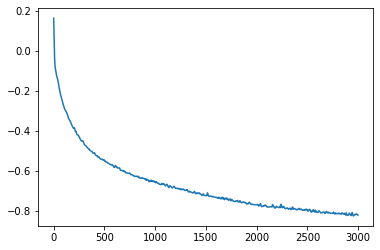

In [40]:
hidden_units_1 = m
hidden_units_2 = m

layer_1 = tf.keras.layers.Dense(units=hidden_units_1, kernel_initializer=initializers.glorot_normal())
layer_2 = tf.keras.layers.Dense(units=hidden_units_2, kernel_initializer=initializers.glorot_normal())# hidden layer: apply weights
out = layers.Dense(K, kernel_initializer=initializers.random_normal(mean=0.0,stddev=1)
                       ,kernel_regularizer=None)  # K (2) classes for nodes

def gnn(node_features, adj_matrix, transform, activation):
    # weight first, then aggregate neighbor features
    #weighted_features = transform(node_features) # apply weights to node features
    #aggregated_features = tf.matmul(adj_matrix, weighted_features) # aggregated neighbor node features
    #return activation(aggregated_features) # apply activation function
    # aggregate neighbor features first, then weight
    aggregated_features = tf.matmul(adj_matrix, tf.cast(node_features, dtype=tf.float32)) # aggregated neighbor node features
    weighted_features = transform(aggregated_features) # apply weights to node features
    return activation(weighted_features) # apply activation function

def cora_gnn(node_features, adj_matrix):
    hidden_1 = gnn(node_features, sample_A2 * adj_matrix, layer_1, tf.nn.relu)
    hidden_2 = gnn(hidden_1, adj_matrix, layer_2, tf.nn.relu)
    # hidden_2 = layers.Dropout(rate=0.4)(hidden_2)
    # logits = gnn(hidden, adj_matrix, layer_2, tf.identity)
    added12 = tf.keras.layers.Add()([hidden_1, hidden_2])
    logits = tf.identity(out(added12))
    # logits = tf.identity(out(hidden_2))
    return logits

learning_rate = 1
test_error_200_A1 = []
epochs = 3000
for epoch in range(epochs):
    run_optimization(node_features, node_labels_100_A1, A_star, test_error_200_A1)
    if epoch % 500 == 0:
        learning_rate = learning_rate * 0.9
fig, ax = plt.subplots()
line1, = ax.plot(np.log10(test_error_200_A1), label='test_error_200_A1')

Iteration 0 | Training loss: 1.6793185 | Val MSE: 1.7557795 | Test MSE 2.019615
Iteration 500 | Training loss: 0.084390916 | Val MSE: 0.15262222 | Test MSE 0.1862312
Iteration 1000 | Training loss: 0.1088206 | Val MSE: 0.10364024 | Test MSE 0.12319681
Iteration 1500 | Training loss: 0.11437859 | Val MSE: 0.075311124 | Test MSE 0.09155859
Iteration 2000 | Training loss: 0.04121597 | Val MSE: 0.055948604 | Test MSE 0.06426779
Iteration 2500 | Training loss: 0.028840754 | Val MSE: 0.042210907 | Test MSE 0.049903233


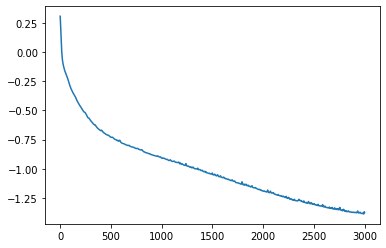

In [41]:
hidden_units_1 = m
hidden_units_2 = m

layer_1 = tf.keras.layers.Dense(units=hidden_units_1, kernel_initializer=initializers.glorot_normal())
layer_2 = tf.keras.layers.Dense(units=hidden_units_2, kernel_initializer=initializers.glorot_normal())# hidden layer: apply weights
out = layers.Dense(K, kernel_initializer=initializers.random_normal(mean=0.0,stddev=1)
                       ,kernel_regularizer=None)  # K (2) classes for nodes

def gnn(node_features, adj_matrix, transform, activation):
    # weight first, then aggregate neighbor features
    #weighted_features = transform(node_features) # apply weights to node features
    #aggregated_features = tf.matmul(adj_matrix, weighted_features) # aggregated neighbor node features
    #return activation(aggregated_features) # apply activation function
    # aggregate neighbor features first, then weight
    aggregated_features = tf.matmul(adj_matrix, tf.cast(node_features, dtype=tf.float32)) # aggregated neighbor node features
    weighted_features = transform(aggregated_features) # apply weights to node features
    return activation(weighted_features) # apply activation function

def cora_gnn(node_features, adj_matrix):
    hidden_1 = gnn(node_features,  adj_matrix, layer_1, tf.nn.relu)
    hidden_2 = gnn(hidden_1, sample_A2 * adj_matrix, layer_2, tf.nn.relu)
    # hidden_2 = layers.Dropout(rate=0.4)(hidden_2)
    # logits = gnn(hidden, adj_matrix, layer_2, tf.identity)
    added12 = tf.keras.layers.Add()([hidden_1, hidden_2])
    logits = tf.identity(out(added12))
    # logits = tf.identity(out(hidden_2))
    return logits

learning_rate = 1
test_error_200_A2 = []
epochs = 3000
for epoch in range(epochs):
    run_optimization(node_features, node_labels_100_A1, A_star, test_error_200_A2)
    if epoch % 500 == 0:
        learning_rate = learning_rate * 0.9
fig, ax = plt.subplots()
line1, = ax.plot(np.log10(test_error_200_A2), label='test_error_200_A2')

In [42]:
# sample=0.5
sample_A5 = (tf.sign(aa-0.5)+1)*0.5
LA.norm(A_star-A_star*sample_A5, 'fro')

1.8766159

Iteration 0 | Training loss: 1.5805815 | Val MSE: 1.5975933 | Test MSE 1.8333218
Iteration 500 | Training loss: 0.5587858 | Val MSE: 0.49417946 | Test MSE 0.52474856
Iteration 1000 | Training loss: 0.42808357 | Val MSE: 0.45375323 | Test MSE 0.46943584
Iteration 1500 | Training loss: 0.41948345 | Val MSE: 0.4429018 | Test MSE 0.45767018
Iteration 2000 | Training loss: 0.37277523 | Val MSE: 0.43175563 | Test MSE 0.44914636
Iteration 2500 | Training loss: 0.53162134 | Val MSE: 0.4235204 | Test MSE 0.43387815


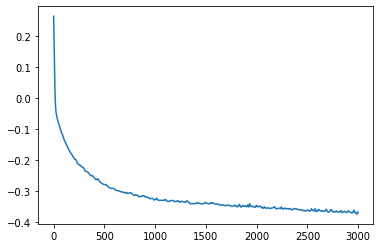

In [43]:
hidden_units_1 = m
hidden_units_2 = m

layer_1 = tf.keras.layers.Dense(units=hidden_units_1, kernel_initializer=initializers.glorot_normal())
layer_2 = tf.keras.layers.Dense(units=hidden_units_2, kernel_initializer=initializers.glorot_normal())# hidden layer: apply weights
out = layers.Dense(K, kernel_initializer=initializers.random_normal(mean=0.0,stddev=1)
                       ,kernel_regularizer=None)  # K (2) classes for nodes

def gnn(node_features, adj_matrix, transform, activation):
    # weight first, then aggregate neighbor features
    #weighted_features = transform(node_features) # apply weights to node features
    #aggregated_features = tf.matmul(adj_matrix, weighted_features) # aggregated neighbor node features
    #return activation(aggregated_features) # apply activation function
    # aggregate neighbor features first, then weight
    aggregated_features = tf.matmul(adj_matrix, tf.cast(node_features, dtype=tf.float32)) # aggregated neighbor node features
    weighted_features = transform(aggregated_features) # apply weights to node features
    return activation(weighted_features) # apply activation function

def cora_gnn(node_features, adj_matrix):
    hidden_1 = gnn(node_features, sample_A5 * adj_matrix, layer_1, tf.nn.relu)
    hidden_2 = gnn(hidden_1, adj_matrix, layer_2, tf.nn.relu)
    # hidden_2 = layers.Dropout(rate=0.4)(hidden_2)
    # logits = gnn(hidden, adj_matrix, layer_2, tf.identity)
    added12 = tf.keras.layers.Add()([hidden_1, hidden_2])
    logits = tf.identity(out(added12))
    # logits = tf.identity(out(hidden_2))
    return logits

learning_rate = 1
test_error_500_A1 = []
epochs = 3000
for epoch in range(epochs):
    run_optimization(node_features, node_labels_100_A1, A_star, test_error_500_A1)
    if epoch % 500 == 0:
        learning_rate = learning_rate * 0.9
fig, ax = plt.subplots()
line1, = ax.plot(np.log10(test_error_500_A1), label='test_error_200_A1')

Iteration 0 | Training loss: 1.6917028 | Val MSE: 1.8973093 | Test MSE 2.156398
Iteration 500 | Training loss: 0.17161155 | Val MSE: 0.17557134 | Test MSE 0.20783637
Iteration 1000 | Training loss: 0.1499097 | Val MSE: 0.14267771 | Test MSE 0.16563278
Iteration 1500 | Training loss: 0.120484576 | Val MSE: 0.12980771 | Test MSE 0.15045004
Iteration 2000 | Training loss: 0.15477112 | Val MSE: 0.119163774 | Test MSE 0.13577448
Iteration 2500 | Training loss: 0.07439671 | Val MSE: 0.10960035 | Test MSE 0.12209027


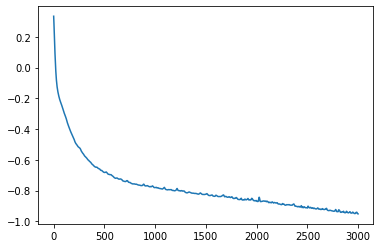

In [44]:
hidden_units_1 = m
hidden_units_2 = m

layer_1 = tf.keras.layers.Dense(units=hidden_units_1, kernel_initializer=initializers.glorot_normal())
layer_2 = tf.keras.layers.Dense(units=hidden_units_2, kernel_initializer=initializers.glorot_normal())# hidden layer: apply weights
out = layers.Dense(K, kernel_initializer=initializers.random_normal(mean=0.0,stddev=1)
                       ,kernel_regularizer=None)  # K (2) classes for nodes

def gnn(node_features, adj_matrix, transform, activation):
    # weight first, then aggregate neighbor features
    #weighted_features = transform(node_features) # apply weights to node features
    #aggregated_features = tf.matmul(adj_matrix, weighted_features) # aggregated neighbor node features
    #return activation(aggregated_features) # apply activation function
    # aggregate neighbor features first, then weight
    aggregated_features = tf.matmul(adj_matrix, tf.cast(node_features, dtype=tf.float32)) # aggregated neighbor node features
    weighted_features = transform(aggregated_features) # apply weights to node features
    return activation(weighted_features) # apply activation function

def cora_gnn(node_features, adj_matrix):
    hidden_1 = gnn(node_features, adj_matrix, layer_1, tf.nn.relu)
    hidden_2 = gnn(hidden_1, sample_A5 * adj_matrix, layer_2, tf.nn.relu)
    # hidden_2 = layers.Dropout(rate=0.4)(hidden_2)
    # logits = gnn(hidden, adj_matrix, layer_2, tf.identity)
    added12 = tf.keras.layers.Add()([hidden_1, hidden_2])
    logits = tf.identity(out(added12))
    # logits = tf.identity(out(hidden_2))
    return logits

learning_rate = 1
test_error_500_A2 = []
epochs = 3000
for epoch in range(epochs):
    run_optimization(node_features, node_labels_100_A1, A_star, test_error_500_A2)
    if epoch % 500 == 0:
        learning_rate = learning_rate * 0.9
fig, ax = plt.subplots()
line1, = ax.plot(np.log10(test_error_500_A2), label='test_error_500_A2')

In [50]:
hidden_units_1 = m
hidden_units_2 = m

layer_1 = tf.keras.layers.Dense(units=hidden_units_1, kernel_initializer=initializers.glorot_normal())
layer_2 = tf.keras.layers.Dense(units=hidden_units_2, kernel_initializer=initializers.glorot_normal())# hidden layer: apply weights
out = layers.Dense(K, kernel_initializer=initializers.random_normal(mean=0.0,stddev=1)
                       ,kernel_regularizer=None)  # K (2) classes for nodes

def gnn(node_features, adj_matrix, transform, activation):
    # weight first, then aggregate neighbor features
    #weighted_features = transform(node_features) # apply weights to node features
    #aggregated_features = tf.matmul(adj_matrix, weighted_features) # aggregated neighbor node features
    #return activation(aggregated_features) # apply activation function
    # aggregate neighbor features first, then weight
    aggregated_features = tf.matmul(adj_matrix, tf.cast(node_features, dtype=tf.float32)) # aggregated neighbor node features
    weighted_features = transform(aggregated_features) # apply weights to node features
    return activation(weighted_features) # apply activation function

def cora_gnn(node_features, adj_matrix):
    hidden_1 = gnn(node_features, adj_matrix, layer_1, tf.nn.relu)
    hidden_2 = gnn(hidden_1, adj_matrix, layer_2, tf.nn.relu)
    # hidden_2 = layers.Dropout(rate=0.4)(hidden_2)
    # logits = gnn(hidden, adj_matrix, layer_2, tf.identity)
    added12 = tf.keras.layers.Add()([hidden_1, hidden_2])
    logits = tf.identity(out(added12))
    # logits = tf.identity(out(hidden_2))
    return logits

learning_rate = 1
test_error_A0 = []
epochs = 3000
for epoch in range(epochs):
    run_optimization(node_features, node_labels_100_A1, A_star, test_error_A0)
    if epoch % 500 == 0:
        learning_rate = learning_rate * 0.9
fig, ax = plt.subplots()
line1, = ax.plot(np.log10(test_error_A0), label='test_error_500_A2')

Iteration 0 | Training loss: 1.329969 | Val MSE: 1.462199 | Test MSE 1.6402075
Iteration 500 | Training loss: 0.11447981 | Val MSE: 0.12754266 | Test MSE 0.14788757
Iteration 1000 | Training loss: 0.07016379 | Val MSE: 0.060343668 | Test MSE 0.0754738
Iteration 1500 | Training loss: 0.03954425 | Val MSE: 0.03223984 | Test MSE 0.04084973


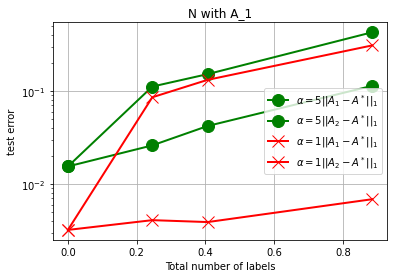

In [49]:
N1 = [0.0, LA.norm(A_star-A_star*sample_A1, np.inf), LA.norm(A_star-A_star*sample_A2, np.inf), LA.norm(A_star-A_star*sample_A5, np.inf)]
# test_A1 = [np.mean(test_error_500_A1[-100:-1]),np.mean(test_error_800_A1[-100:-1]),np.mean(test_error_1000_A1[-100:-1]),test_error_1500_A1[-1],np.mean(test_error_1800_A1[-100:-1])]
# test_A2 = [np.mean(test_error_500_A2[-100:-1]),np.mean(test_error_800_A2[-100:-1]),np.mean(test_error_1000_A2[-100:-1]),test_error_1500_A2[-1],np.mean(test_error_1800_A2[-1])]
# test_A3 = [np.mean(test_error_500_A3[-100:-1]),np.mean(test_error_800_A3[-100:-1]),np.mean(test_error_1000_A3[-100:-1]),test_error_1500_A3[-1],np.mean(test_error_1800_A3[-100:-1])]
test_A1_alpha5 = [np.mean(test_error_A0[-100:-1]), np.mean(test_error_100_A1[-100:-1]), np.mean(test_error_200_A1[-100:-1]), np.mean(test_error_500_A1[-100:-1])]
test_A2_alpha5 = [np.mean(test_error_A0[-100:-1]), np.mean(test_error_100_A2[-100:-1]), np.mean(test_error_200_A2[-100:-1]), np.mean(test_error_500_A2[-100:-1])]
fig, ax = plt.subplots()

line1, = ax.plot(N1, test_A1_alpha5, label=r'$\alpha=5 ||A_1 - A^*||_1$',color='g', marker='o', markevery=1, linewidth=2, markersize=12)
line2, = ax.plot(N1, test_A2_alpha5, label=r'$\alpha=5 ||A_2 - A^*||_1$',color='g', marker='o', markevery=1, linewidth=2, markersize=12)
line3, = ax.plot(N1, test_A1_alpha1, label=r'$\alpha=1 ||A_1 - A^*||_1$',color='r', marker='x', markevery=1, linewidth=2, markersize=12)
line4, = ax.plot(N1, test_A2_alpha1, label=r'$\alpha=1 ||A_2 - A^*||_1$',color='r', marker='x', markevery=1, linewidth=2, markersize=12)



ax.set(xlabel='Total number of labels', ylabel='test error', title='N with A_1')
ax.grid()
ax.legend()
plt.yscale('log')
plt.savefig('N with A_1')
plt.show()


In [ ]:
c=100
p1 = 0.05
p2 = 0.1
d1 = N*p1
d2 = N*p2
adj_matrix = generateAdj(N, 0.1, 0.05)
norm_adj_matrix = generate_norm_adj_matrix(adj_matrix)

In [ ]:
k = int(d1*(d2/d1)**0.5)
x = norm_adj_matrix[0:100, 0:100]
values, indices = tf.nn.top_k(x, k)


In [ ]:
my_range = tf.expand_dims(tf.range(0, indices.get_shape()[0]), 1)  # will be [[0], [1]]
my_range_repeated = tf.tile(my_range, [1, k])  # will be [[0, 0], [1, 1]]

# change shapes to [N, k, 1] and [N, k, 1], to concatenate into [N, k, 2]
full_indices = tf.concat([tf.expand_dims(my_range_repeated, 2), tf.expand_dims(indices, 2)], axis=2)
full_indices = tf.reshape(full_indices, [-1, 2])
mask = np.zeros([900,900])
for i in range(full_indices.shape[0]):
    mask[full_indices[i,:]]=1
y = tf.convert_to_tensor(mask, dtype=tf.float32)
tf.math.multiply(norm_adj_matrix[0:900, 0:900],y)


In [ ]:
tf.tensordot(values[:,-1], tf.ones(900), axes=0)
x

In [ ]:
aa = 0.5*(1+ tf.sign(x-tf.tensordot(values[:,-1], tf.ones(c), axes=0)) )*x
aa

In [ ]:
c = 2
adj_matrix = generateAdj(5, 1, 0.01)
norm_adj_matrix = generate_norm_adj_matrix(adj_matrix)
norm_adj_matrix

In [ ]:
sum(tf.sign(x[:,-1]))

In [ ]:
x = tf.constant([[6., 2., 0.], [0., 4., 5.],[10., 4., 5.]])  # of type tf.float32

k = 2
values, indices = tf.nn.top_k(x, k, sorted=False)  # indices will be [[0, 1], [1, 2]], values will be [[6., 2.], [4., 5.]]

# We need to create full indices like [[0, 0], [0, 1], [1, 2], [1, 1]]
my_range = tf.expand_dims(tf.range(0, indices.get_shape()[0]), 1)  # will be [[0], [1]]
my_range_repeated = tf.tile(my_range, [1, k])  # will be [[0, 0], [1, 1]]

# change shapes to [N, k, 1] and [N, k, 1], to concatenate into [N, k, 2]
full_indices = tf.concat([tf.expand_dims(my_range_repeated, 2), tf.expand_dims(indices, 2)], axis=2)
full_indices = tf.reshape(full_indices, [-1, 2])

# to_substract = tf.sparse.to_dense(full_indices, x.get_shape(), tf.reshape(values, [-1]), default_value=0.)

# res = x - to_substract

In [ ]:
indices

In [ ]:
full_indices

In [ ]:
full_indices[0,:]

In [ ]:
mask = np.zeros([3,3])

In [ ]:
for i in range(6):
    mask[full_indices[i,:]]=1

In [ ]:
mask

In [ ]:
np.multiply(x, mask)

In [ ]:
full_indices.shape[0]

In [ ]:
y = tf.convert_to_tensor(mask, dtype=tf.float32)

In [ ]:
y = tf.convert_to_tensor(mask, dtype=tf.float32)
tf.math.multiply(x,y)